In [1]:
import pandas as pd
import numpy as np
import pydicom
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

elementdict = {'STUDYDATE' : 3, 'STUDYTIME' : 4, 'AGE' : 14, 'SEX' : 13, 
               'VIEWPOSITION' : 16}

In [2]:
folder = './data/'
file1 = folder + 'stage_2_train_labels.csv'
file2 = folder + 'stage_2_detailed_class_info.csv'

In [3]:
dflabel = pd.read_csv(file1)
dflabel.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [4]:
dfinfo = pd.read_csv(file2)
dfinfo.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [5]:
dfinfo['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

In [6]:
print(len(dflabel), len(dfinfo), len(dflabel.patientId.unique()), len(dfinfo.patientId.unique()))

30227 30227 26684 26684


In [7]:
def GetClass(x):
    return list(dfinfo[dfinfo.patientId == x]['class'].unique())

dflabel['class'] = pd.Series(map(GetClass, dflabel.patientId))
dflabel['class'] = dflabel['class'].apply(lambda x: x[0]) 
dflabel['count'] = dflabel['class'].apply(lambda x: len(x))

df = dflabel.copy()

In [8]:
def ExtractInfo(dcmdata, identifiers):
    lstdata = list(dcmdata.elements())
    retval = []
    for idx in identifiers:
        try:
            tempval = lstdata[identifiers[idx]].value
            retval.append(tempval)
        except:
            print('Unable to extract', idx)

    return retval

lstvals = []
lstpixels = []
for item in range(len(df)):
    pid = df.iloc[item]['patientId']

    if item % 5000 == 0: 
        print('Processings patient {0} - {1}'.format(item, pid))
    
    file = folder + 'stage_2_train_images/' + pid + '.dcm'
    datadcm = pydicom.read_file(file)
    lstvals.append(ExtractInfo(datadcm, elementdict))
    lstpixels.append(datadcm.pixel_array)
    
dfelements = pd.DataFrame(lstvals)
dfelements['PIXELS'] = lstpixels
dfelements.columns = ['STUDYDATE', 'STUDYTIME', 'AGE', 'SEX', 'VIEWPOSITION', 'PIXELS']
dfelements.head()

Processings patient 0 - 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Processings patient 5000 - 43471655-e6fa-4a8d-bf0a-45ee62343d07
Processings patient 10000 - 6bc8aad2-30ea-4daf-94cb-4b65c6e8d0c2
Processings patient 15000 - 934d2f15-76ae-4a2c-817f-a3b022b0cc10
Processings patient 20000 - b84b2a5f-122b-423c-9556-08bdf7f179c3
Processings patient 25000 - e047d647-ba4a-40cf-a44e-41b4a3982945
Processings patient 30000 - 2cb272c0-90db-4e36-8a78-ed072efcdaa2


,STUDYDATE,STUDYTIME,AGE,SEX,VIEWPOSITION,PIXELS
0,b'19010101',b'000000.00 ',b'51',b'F ',b'PA',"[[144, 128, 114, 105, 94, 82, 72, 66, 59, 54, ..."
1,b'19010101',b'000000.00 ',b'48',b'F ',b'PA',"[[31, 24, 19, 14, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0..."
2,b'19010101',b'000000.00 ',b'19',b'M ',b'AP',"[[4, 12, 11, 10, 10, 8, 9, 7, 10, 10, 10, 9, 9..."
3,b'19010101',b'000000.00 ',b'28',b'M ',b'PA',"[[209, 211, 212, 212, 210, 207, 205, 204, 204,..."
4,b'19010101',b'000000.00 ',b'32',b'F ',b'AP',"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,..."


In [9]:
df[['studydate', 'studytime', 'age', 'sex', 'viewposition', 'pixels']] = dfelements.copy()
df['imagesize'] = df.pixels.apply(lambda x: x.shape)
df = df[['patientId', 'x', 'y', 'width', 'height', 
         'studydate', 'studytime', 'age', 'sex', 
         'viewposition', 'imagesize', 'Target', 'class', 'pixels']]
df.age = df.age.apply(lambda x: np.int32(x))

df.head()

,patientId,x,y,width,height,studydate,studytime,age,sex,viewposition,imagesize,Target,class,pixels
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',51,b'F ',b'PA',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[144, 128, 114, 105, 94, 82, 72, 66, 59, 54, ..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',48,b'F ',b'PA',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[31, 24, 19, 14, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',19,b'M ',b'AP',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[4, 12, 11, 10, 10, 8, 9, 7, 10, 10, 10, 9, 9..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',28,b'M ',b'PA',"(1024, 1024)",0,Normal,"[[209, 211, 212, 212, 210, 207, 205, 204, 204,..."
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,b'19010101',b'000000.00 ',32,b'F ',b'AP',"(1024, 1024)",1,Lung Opacity,"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,..."


In [10]:
del(dfelements)
del(dfinfo)
del(dflabel)

Age distribution by class


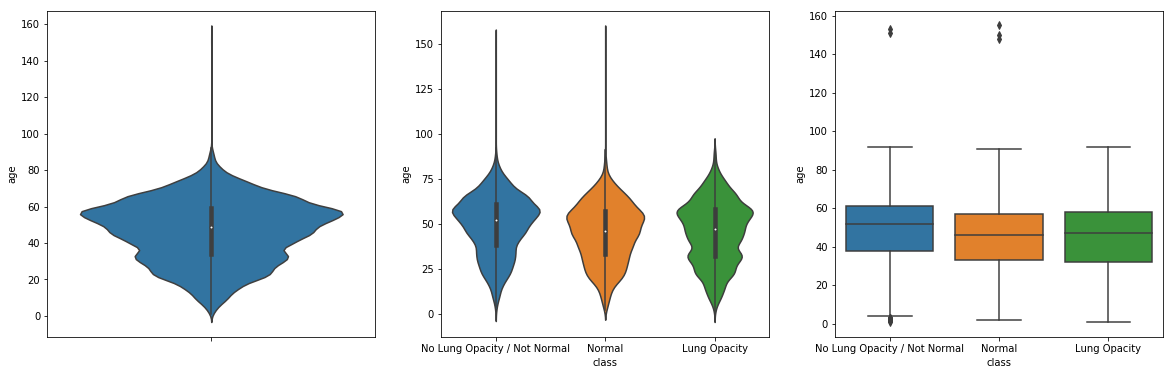

Age distribution by sex


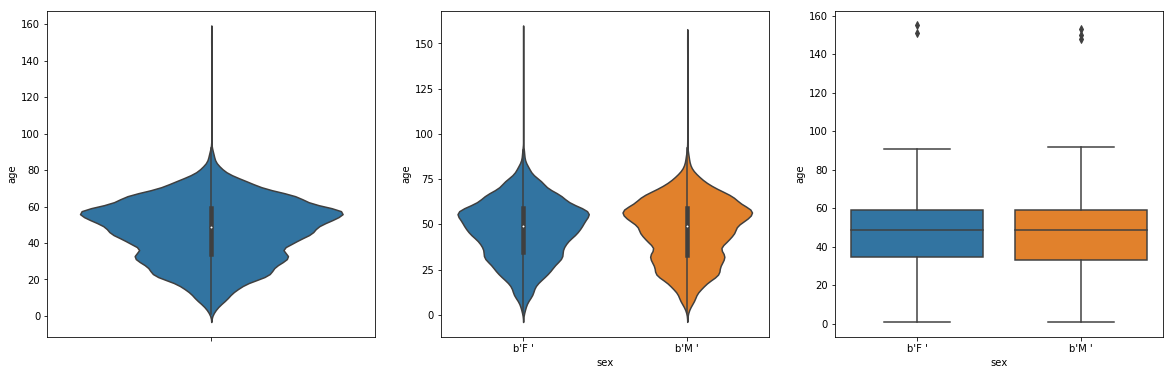

In [11]:
fig, axes = plt.subplots(1, 3, figsize = (20, 6))

print('Age distribution by class')
sb.violinplot(y ='age', data = df, ax=axes[0]) 
sb.violinplot(x ='class', y ='age', data = df, ax=axes[1]) 
sb.boxplot(x ='class', y ='age', data = df, ax=axes[2]) 
plt.show()

fig, axes = plt.subplots(1, 3, figsize = (20, 6))

print('Age distribution by sex')
sb.violinplot(y ='age', data = df, ax=axes[0]) 
sb.violinplot(x ='sex', y ='age', data = df, ax=axes[1]) 
sb.boxplot(x ='sex', y ='age', data = df, ax=axes[2]) 
plt.show()

Image view for class - No Lung Opacity / Not Normal


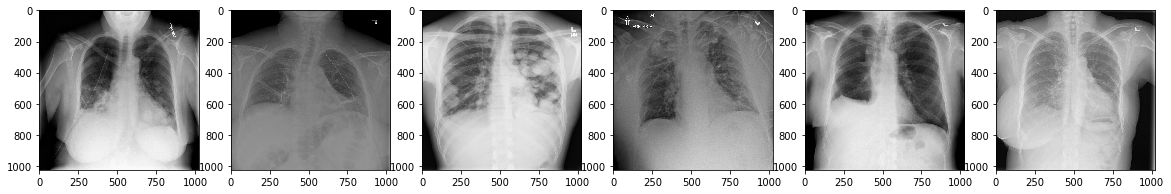

Image view for class - Normal


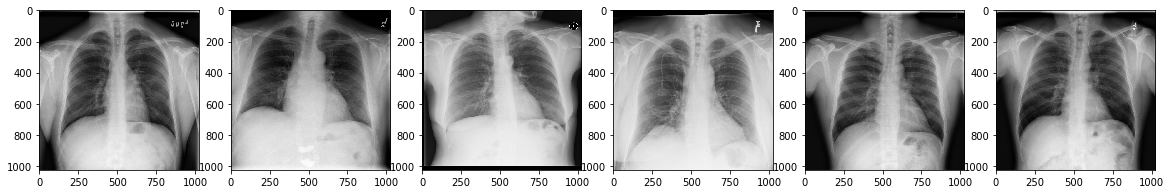

Image view for class - Lung Opacity


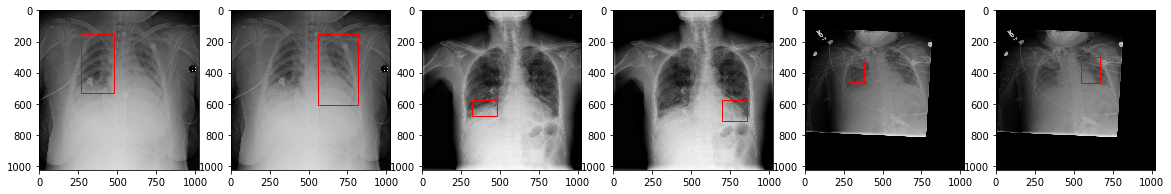

In [12]:
for cls in df['class'].unique():
    dftemp = df[df['class'] == cls].head(6)
    print('Image view for class - {0}'.format(cls))
    fig, axes = plt.subplots(1, len(dftemp), figsize = (20, 6))
    for i in range(len(dftemp)):
        pixels = dftemp.iloc[i].pixels
        dimensions = dftemp.iloc[i][['x', 'y', 'width', 'height']]
        axes[i].imshow(pixels, cmap='gray')
        
        if not np.isnan(dimensions[0]):
            rect = patches.Rectangle((dimensions[0],dimensions[1]),
                                     dimensions[2],dimensions[3], 
                                     linewidth=1, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)
        
    plt.show()

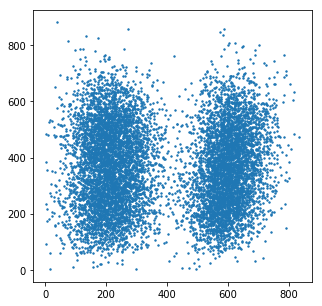

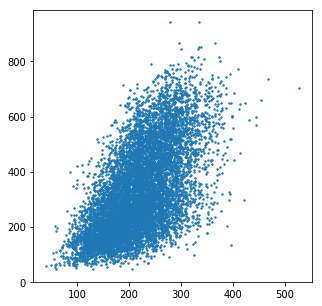

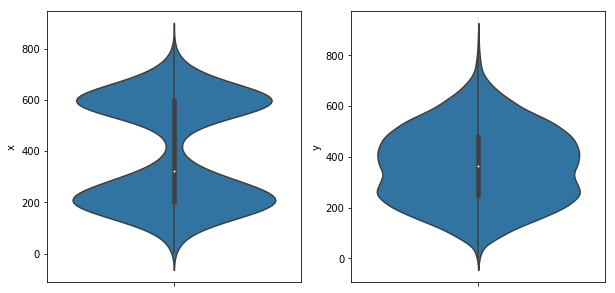

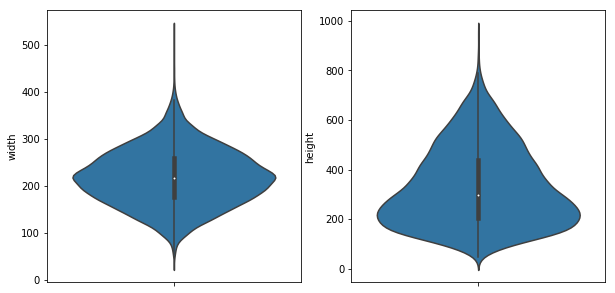

In [13]:
fig, axes = plt.subplots(1, 1, figsize = (5, 5))
plt.scatter(df.x, df.y, s=2)
plt.show()

fig, axes = plt.subplots(1, 1, figsize = (5, 5))
plt.scatter(df.width, df.height, s=2)
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sb.violinplot(data=df[df.Target == 1],  y='x', ax=axes[0])
sb.violinplot(data=df[df.Target == 1],  y='y', ax=axes[1])
plt.show()

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sb.violinplot(data=df[df.Target == 1],  y='width', ax=axes[0])
sb.violinplot(data=df[df.Target == 1],  y='height', ax=axes[1])
plt.show()

In [14]:
df.corr()

,x,y,width,height,age,Target
x,1.000000,0.007604,-0.058665,0.008256,-0.016081,NaN
y,0.007604,1.000000,-0.299897,-0.645369,0.104195,NaN
width,-0.058665,-0.299897,1.000000,0.597461,0.027666,NaN
height,0.008256,-0.645369,0.597461,1.000000,-0.006048,NaN
age,-0.016081,0.104195,0.027666,-0.006048,1.000000,-0.056878
Target,NaN,NaN,NaN,NaN,-0.056878,1.000000


In [17]:
df

,patientId,x,y,width,height,studydate,studytime,age,sex,viewposition,imagesize,Target,class,pixels
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',51,b'F ',b'PA',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[144, 128, 114, 105, 94, 82, 72, 66, 59, 54, ..."
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',48,b'F ',b'PA',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[31, 24, 19, 14, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0..."
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',19,b'M ',b'AP',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[4, 12, 11, 10, 10, 8, 9, 7, 10, 10, 10, 9, 9..."
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',28,b'M ',b'PA',"(1024, 1024)",0,Normal,"[[209, 211, 212, 212, 210, 207, 205, 204, 204,..."
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,b'19010101',b'000000.00 ',32,b'F ',b'AP',"(1024, 1024)",1,Lung Opacity,"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,..."
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,b'19010101',b'000000.00 ',32,b'F ',b'AP',"(1024, 1024)",1,Lung Opacity,"[[0, 1, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,..."
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',54,b'M ',b'AP',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,b'19010101',b'000000.00 ',78,b'M ',b'PA',"(1024, 1024)",0,No Lung Opacity / Not Normal,"[[240, 239, 237, 229, 216, 204, 188, 172, 161,..."
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,b'19010101',b'000000.00 ',75,b'M ',b'PA',"(1024, 1024)",1,Lung Opacity,"[[60, 49, 39, 31, 22, 17, 13, 9, 5, 4, 3, 2, 1..."
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,b'19010101',b'000000.00 ',75,b'M ',b'PA',"(1024, 1024)",1,Lung Opacity,"[[60, 49, 39, 31, 22, 17, 13, 9, 5, 4, 3, 2, 1..."
